Projet 4 - Anticipez les besoins en consommation de bâtiments - Cleaning
>-
# 1. Initialisation, visualization

>>-
## 11. Imports

>>>-
### 111. Package imports

In [1]:
import numpy as np              # fast thus always used
import pandas as pd             # fast
pd.set_option("display.max_rows", 20, "display.max_columns", None)
import matplotlib.pyplot as plt # slow: 233 ns
import seaborn as sns           # SLOW BUT: 80.4 ns
sns.set_style("whitegrid")      # "ticks", "white"
import re
import my
from scipy import interpolate   # FAST BUT: 319 ns ± 2.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
#  %timeit import geopandas     # SLOW 
#import os
#import sys
from IPython.display import clear_output
import warnings

>>>-
### 112. Data imports

In [2]:
df = pd.read_csv('2016_Building_Energy_Benchmarking.csv') #, sep='\t')

>>-
## 12. Data visualization - Familiarisation avec les indicateurs fournis

In [3]:
pd.set_option("display.max_rows", 20, "display.max_columns", None)
display(df.shape)
#print(list(df.columns))
display(df.head())

(3376, 46)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


df globalement bien rempli à première vue mais beaucoup trop d'indicateurs et quelques petits problèmes à nettoyer.
>>>-
### 121. Feature categorization by data type (subjective interpretation, by hand).

In [4]:
%%script echo skipped
cols_categorielles = []
for co in df.columns:
    print(co)
    display(df[co].head(8))
    is_categorielle = input('Est-ce que ' + co + ' est une colonne catégorielle ? ("1" et Enter si oui, juste Enter si non)')
    clear_output()
    if is_categorielle:
        cols_categorielles.append(co)
print('cols_categorielles =', cols_categorielles)

Couldn't find program: 'echo'


Cette cell ↑ m'a servi à renseigner la liste. Cette cell ↓ sauve la liste. Je les ai run une fois et je les skip (fastidieuses et désormais inutiles).  
Cette étape nécessite de s'être un peu familiarisé avec le df, à partir du head() au minimum.

In [5]:
%%script echo skipped
#with open("cols_categorielles.txt", "w") as file: # Devrait aussi fonctionner
#    file.write(str(cols_categorielles))
with open("cols_categorielles.txt", "w") as f:
    for i in cols_categorielles:
        f.write(i + "\n")

Couldn't find program: 'echo'


Maintenant je load la liste.

In [6]:
#with open("cols_categorielles.txt", "r") as file: # Devrait aussi fonctionner
#    cols_cat = eval(file.readline())
cols_cat = []
with open("cols_categorielles.txt", "r") as f:
    for i in f:
        cols_cat.append(i.strip())
cols_num = list(set(df.columns).difference(set(cols_cat)))
#display(cols_cat)
#display(cols_num)

Séparation des indicateurs en deux listes en vue de traitements OHE et Scaler séparés.
>>>-
### 122. Variété de valeurs que prend chaque indicateur (.unique())
Les colonnes à 1 valeur sont inutiles, ensuite je dois trouver les colonnes catégorielles (y compris celles renseignées sous forme de valeurs numériques) et supprimer celles {qui contiennent exactement une valeur unique avec frequency > 10% ET aucune autre valeur unique avec frequency > 1%} et celles {qui ne contiennent aucune valeur unique avec frequency > 10 (vraiment 10 hein, pas 10%)}.

>>>>-
#### 1221. Observation de la variance des indicateurs catégoriels

In [7]:
for co in cols_cat:
    uniqs = df.loc[:,co].unique().shape[0]
    uniqs2 = 100*uniqs/df.shape[0]
    print(f"{(co + ':'):40}", '{a:5.0f} {b:8.2f}%'.format(a = uniqs, b = uniqs2))
    #if uniqs > .9*df.shape[0]:
    #    cols_to_drop.append(co)
#print('cols_to_drop =', cols_to_drop)

OSEBuildingID:                            3376   100.00%
DataYear:                                    1     0.03%
BuildingType:                                8     0.24%
PrimaryPropertyType:                        24     0.71%
PropertyName:                             3362    99.59%
Address:                                  3354    99.35%
City:                                        1     0.03%
State:                                       1     0.03%
ZipCode:                                    56     1.66%
TaxParcelIdentificationNumber:            3268    96.80%
CouncilDistrictCode:                         7     0.21%
Neighborhood:                               19     0.56%
ListOfAllPropertyUseTypes:                 467    13.83%
LargestPropertyUseType:                     57     1.69%
SecondLargestPropertyUseType:               51     1.51%
ThirdLargestPropertyUseType:                45     1.33%
YearsENERGYSTARCertified:                   66     1.95%
DefaultData:                   

Certaines loops contiennent une seule valeur unique, d'autres 100% de valeurs uniques.  
Dans ces deux cas elles ne contiennent aucune information.  

In [8]:
df['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [9]:
cols_to_drop = []

<a id="anchor2"></a>

In [10]:
for co in cols_cat:
    vcu = df.loc[:,co].value_counts().unique()
    indice_de_variance = len(vcu)
    if indice_de_variance < 2:
        cols_to_drop.append(co)
    if indice_de_variance < 12:
        print('{a:34} {b:2} {c:4} {d:1}'.format(a = (co + ':'), b = indice_de_variance, c = '', d = ('len(' + str(vcu) + ')')))
    else:
        print('{a:34} {b:2} {c:4} {d:1}'.format(a = (co + ':'), b = indice_de_variance, c = '', d = ('len(' + str(vcu)[0:60] + '...])')))

OSEBuildingID:                      1      len([1])
DataYear:                           1      len([3376])
BuildingType:                       8      len([1460 1018  580  110   98   85   24    1])
PrimaryPropertyType:               22      len([987 564 293 256 187 173 139 133 105  91  77  71  53  45  40...])
PropertyName:                       3      len([3 2 1])
Address:                            3      len([4 2 1])
City:                               1      len([3376])
State:                              1      len([3376])
ZipCode:                           28      len([294 251 243 230 191 186 169 167 161 152 129 124 101  99  93...])
TaxParcelIdentificationNumber:      6      len([8 5 4 3 2 1])
CouncilDistrictCode:                7      len([1037  596  509  367  338  282  247])
Neighborhood:                      19      len([573 453 423 375 280 251 210 166 145 126 107  95  80  42  27...])
ListOfAllPropertyUseTypes:         36      len([866 464 139 135 120 101  61  56  52  51  48  44

\[1\] signifie que la colonne ne propose qu'une seule valeur.  
\[3376\] signifie que la colonne propose autant de valeurs différentes que d'éléments dans le tableau (raisonnable pour une information numérique continue, mais là ce sont des colonnes catégorielles donc l'information contenue dans ces colonnes est nulle). 
Une liste de longueur > 3 signifie que la colonne contient probablement beaucoup d'informations (sauf si c'est \[3367 4 3 2\] par exemple).  

J'ai créé un indice qui me donne une idée de la quantité d'information contenue dans chaque indicateur:
- i<2    signifie que l'indicateur ne contient aucune information.
- 1<i<10 il faut voir plus en détails.
- 9<i    l'indicateur contient forcément beaucoup d'information car il a beaucoup de valeurs uniques différentes et beaucoup d'entre elles apparaissent plus d'une fois.

Par ailleurs, tout ce qui finit par [... 1] contient des valeurs uniques qui n'apparaissent qu'une seule fois, ce qui est lourd en vue du OHE.

In [11]:
cols_to_drop

['OSEBuildingID', 'DataYear', 'City', 'State', 'Comments']

J'ai indiqué quelles colonnes contiennent le moins d'information.
>>>>-
#### 1222. Détail des indicateurs catégoriels avec peu de variance  
D'après [cet output](#anchor2), je dois maintenant m'intéresser à:
- 'PropertyName', 'Address' qui ont beaucoup de valeurs uniques dont aucune n'est répétée plus de 4 fois, donc très peu d'information.
- 'TaxParcelIdentificationNumber', 'YearsENERGYSTARCertified', 'Outlier' dont la composition n'est pas triviale à interpréter.
- 'NumberofBuildings', 'DefaultData', 'ComplianceStatus' où tous les bâtiments sauf qques exceptions ont la même valeur.

In [12]:
df['PropertyName'].value_counts().head()

Northgate Plaza               3
Canal Building                2
Jefferson Court Apartments    2
Bayview Building              2
Crestview Apartments          2
Name: PropertyName, dtype: int64

In [13]:
df['Address'].value_counts().head()

2600 SW Barton St              4
2203 Airport Way S             4
309 South Cloverdale Street    4
516 1st Ave W                  2
201 Thomas St.                 2
Name: Address, dtype: int64

In [14]:
df['TaxParcelIdentificationNumber'].value_counts().head()

1625049001    8
3224049012    5
0925049346    5
0002400002    5
3624039009    4
Name: TaxParcelIdentificationNumber, dtype: int64

In [15]:
df['YearsENERGYSTARCertified'].value_counts().head()

2016        14
20172016     8
2017         7
20162015     6
2014         6
Name: YearsENERGYSTARCertified, dtype: int64

In [16]:
df['Outlier'].value_counts().head()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [17]:
df['NumberofBuildings'].value_counts().head()

1.0    3175
0.0      92
2.0      37
3.0      22
4.0      12
Name: NumberofBuildings, dtype: int64

In [18]:
df['DefaultData'].value_counts().head()

False    3263
True      113
Name: DefaultData, dtype: int64

In [19]:
df['ComplianceStatus'].value_counts().head()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

'Outlier' contient clairement une information importante.  
'NumberofBuildings' est certainement une information utile. (Il contient certains zéros mais si ce sont des parkings ça fait sens.)  
Le reste me semble peu intéressant.

In [20]:
cols_to_drop.append('PropertyName')
cols_to_drop.append('Address')
cols_to_drop.append('TaxParcelIdentificationNumber')
cols_to_drop.append('YearsENERGYSTARCertified')
cols_to_drop.append('DefaultData')
cols_to_drop.append('ComplianceStatus')

J'ai identifié davantage d'indicateurs inintéressants à supprimer.
>>>>-
#### 1223. Cas problématique d'indicateur formé par concaténation.
D'après [cet output](#anchor2), 'ListOfAllPropertyUseTypes' est un indicateur très intéressant, il y a pourtant un piège ici. Détaillons tous les indicateurs restants pour voir.

In [21]:
df['BuildingType'].value_counts().head()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Name: BuildingType, dtype: int64

In [22]:
df['PrimaryPropertyType'].value_counts().head()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Name: PrimaryPropertyType, dtype: int64

In [23]:
df['LargestPropertyUseType'].value_counts().head()

Multifamily Housing           1667
Office                         498
Non-Refrigerated Warehouse     199
K-12 School                    139
Other                          102
Name: LargestPropertyUseType, dtype: int64

In [24]:
df['SecondLargestPropertyUseType'].value_counts().head()

Parking         976
Office          215
Retail Store    155
Other            59
Restaurant       40
Name: SecondLargestPropertyUseType, dtype: int64

In [25]:
df['ThirdLargestPropertyUseType'].value_counts().head()

Retail Store    110
Office          105
Parking          71
Restaurant       56
Other            49
Name: ThirdLargestPropertyUseType, dtype: int64

In [26]:
df['ListOfAllPropertyUseTypes'].value_counts().head()

Multifamily Housing             866
Multifamily Housing, Parking    464
Office                          139
K-12 School                     135
Office, Parking                 120
Name: ListOfAllPropertyUseTypes, dtype: int64

In [27]:
df['ZipCode'].value_counts().head()

98109.0    294
98104.0    251
98122.0    243
98101.0    230
98105.0    191
Name: ZipCode, dtype: int64

In [28]:
df['CouncilDistrictCode'].value_counts().head()

7    1037
3     596
2     509
4     367
5     338
Name: CouncilDistrictCode, dtype: int64

In [29]:
df['Neighborhood'].value_counts().head()

DOWNTOWN                 573
EAST                     453
MAGNOLIA / QUEEN ANNE    423
GREATER DUWAMISH         375
NORTHEAST                280
Name: Neighborhood, dtype: int64

- 'BuildingType' me servira à supprimer les habitations (demandé par l'énoncé) puis éventuellement je m'en débarrasserai car il ne contiendra plus beaucoup d'information.
- 'PrimaryPropertyType' devrait par conséquent perdre ses entrées "family" et je devrai alors vérifier s'il contient toujours une information substantielle.
- Par définition 'SecondLargestPropertyUseType' et 'ThirdLargestPropertyUseType' sont des indicateurs moins significatifs que 'LargestPropertyUseType' donc je n'ai pas trop envie de les garder, à voir.
- 'ListOfAllPropertyUseTypes' est doublement problématique car il est une concaténation d'infos déjà contenues dans d'autres colonnes et parce que cette concaténation crée de nouvelles valeurs uniques donc une illusion d'information intéressante.
- 'ZipCode', 'CouncilDistrictCode' et 'Neighborhood' sont probablement redondants mais pour l'instant je n'ai aucune raison de supprimer l'un d'entre eux.

In [30]:
cols_to_drop.append('SecondLargestPropertyUseType')
cols_to_drop.append('ThirdLargestPropertyUseType')
cols_to_drop.append('ListOfAllPropertyUseTypes')
#cols_to_drop.append('PrimaryPropertyType')

>>>>-
#### 1224. Drop the columns and save

In [31]:
df.drop(cols_to_drop, axis = 1, inplace = True)
for i in cols_to_drop:
    cols_cat.remove(i)

In [32]:
df.to_csv('df1.csv')
df1 = df.copy()
df.head(2)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,88434.0,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.0,1.156514e+06,3946027.0,12764.52930,1276453.0,NaN,249.98,2.83
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,Hotel,83880.0,15064.0,4622.0,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.0,9.504252e+05,3242851.0,51450.81641,5145082.0,NaN,295.86,2.86


In [33]:
#df = df1

J'ai supprimé des colonnes catégorielles qui semblent n'apporter aucune information.
>>>-
### 124. Features numériques parasites (corrélations)

In [34]:
cmaps = ['vlag', 'twilight_shifted', 'RdBu_r', 'coolwarm', 'seismic', 'rainbow', 'Greys_r']

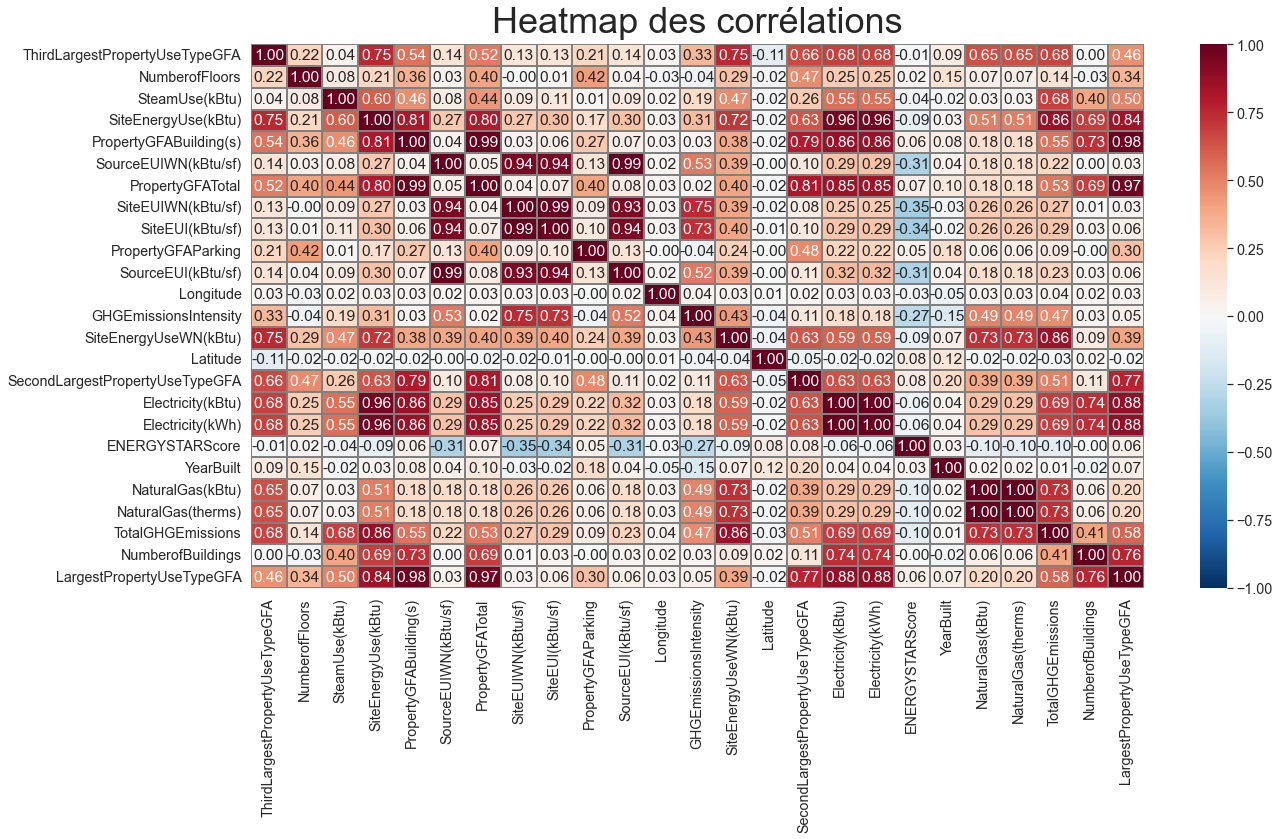

In [35]:
plt.figure(figsize=(20, 10))
sns.set(font_scale=1.3)
crrl = df.loc[:,cols_num].corr()
corrlmap = sns.heatmap(crrl, vmin=-1, vmax=1, annot=True, cmap=cmaps[2], fmt='3.2f', linewidths=0.01, linecolor='gray', cbar=True, )
corrlmap.set_title('Heatmap des corrélations', fontdict={'fontsize':36}, pad=12)
plt.savefig('corrlmap1.png', dpi=300, bbox_inches='tight')

https://data.seattle.gov/dataset/2020-Building-Energy-Benchmarking/auez-gz8p/data  
Faisons un feature engineering à la main ici car certains indicateurs sont trop similaires.
1. Certains sont juste exprimés dans une unité différente. Toutes les grandeurs énergétiques ont un indicateur renseigné en kBtu donc je garde ceux-ci pour pouvoir facilement les comparer ou les sommer.
2. 'PropertyGFATotal' et 'LargestPropertyUseTypeGFA' sont redondants avec leurs sources 'PropertyGFAParking', 'PropertyGFABuilding(s)'.
3. 'SiteEUI', 'SourceEUI' et 'SiteEnergyUse' ont une version WN (moyennée dans le temps sur plusieurs années) donc je garde l'indicateur moyenné.
4. Le site energy use WN simple m'intéresse peu car c'est certainement une simple somme de electricity, steam et gas. Le site energy use intensity (par square meter) est à peine plus intéressant car j'imagine qu'il est juste obtenu après division par le GroundFloorArea, mais c'est une target raisonnable qui permet de comparer la qualité de différents bâtiments même lorsqu'ils ont une taille différente.
5. En suivant à peu près le même raisonnement je vais me débarrasser de GHGE (GreenHouseGases) pour ne garder que GHGEI.
6. Il reste Source qui semble redondant avec site energy use. Je ne comprends pas ce que cet indicateur représente exactement mais je dois le retirer car il est corrélé à l'une de mes targets.

In [36]:
print((df['PropertyGFATotal'] - df['PropertyGFAParking'] - df['PropertyGFABuilding(s)']).mean())
print((df['PropertyGFATotal'] - df['PropertyGFAParking'] - df['PropertyGFABuilding(s)']).std())

0.0
0.0


Donc tot est la somme des deux donc je le retire.

Par ailleurs je suppose d'après son nom que est simplement la somme de, vérifions.

In [37]:
#nrj = df.loc[:,['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']].sum() # Ne fonctionne pas, donne juste des NaN
nrj = df['SteamUse(kBtu)'] + df['Electricity(kBtu)'] + df['NaturalGas(kBtu)']
(nrj - df['SiteEnergyUse(kBtu)']).head()

0   -0.50
1    0.00
2   -6.00
3   -0.75
4   -1.00
dtype: float64

Ici il semble que la colonne SiteEnergyUse est une simple somme des trois autres.

In [38]:
(nrj - df['SiteEnergyUse(kBtu)']).describe()

count    3.367000e+03
mean    -5.842272e+04
std      2.353046e+06
min     -1.318641e+08
25%     -5.000000e-01
50%     -2.500000e-01
75%      9.370000e-02
max      4.993620e+06
dtype: float64

En fait non.

(0.0, 10000000.0)

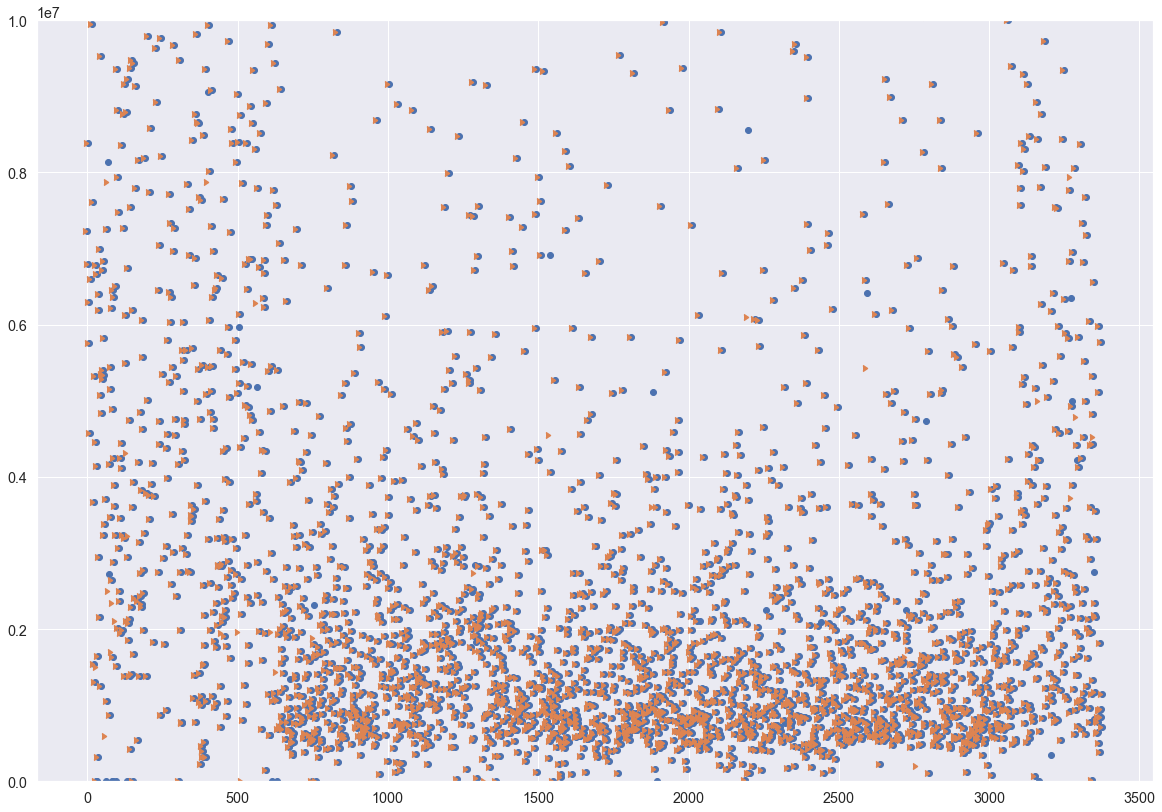

In [39]:
plt.figure(figsize=(20,14))
plt.scatter(df.index,df['SiteEnergyUse(kBtu)'])
plt.scatter(df.index,nrj,marker=5)
plt.ylim(0,1e7)

En fait il y a très peu de cas où le SiteEnergyUse et la somme des trois {energy}Use ne coïncident pas.  
Je ne vois pas l'intérêt pour l'instant de trouver exactement à quoi sont dues ces différences.  
Cependant, je ne sais pas s'il faut alors supprimer ces trois features avant d'appeler les estimateurs (non seulement pour éviter le data leakage mais surtout parce qu'en pratique si ces 3 relevés ont déjà été faits dans le bâtiment alors on n'a pas vraiment besoin d'un outil de machine learning pour conclure sur la conso totale de ce bâtiment), pour l'instant je les garde.  
(Si ma machine converge vers un programme très simple qui somme ces 3 features et ignore toutes les autres alors elle sera incapable de prédire quoi que ce soit lorsque je lui donnerai un nouveau bâtiment dont aucun de ces 3 relevés n'a été effectué. :/)

In [40]:
cols_to_drop = ['PropertyGFATotal','LargestPropertyUseTypeGFA','SiteEUI(kBtu/sf)','SourceEUI(kBtu/sf)','SourceEUIWN(kBtu/sf)','SiteEnergyUse(kBtu)','SiteEnergyUseWN(kBtu)','Electricity(kWh)','NaturalGas(therms)','TotalGHGEmissions']

In [41]:
df.drop(cols_to_drop, axis = 1, inplace = True)
for i in cols_to_drop:
    cols_num.remove(i)

J'ai supprimé des colonnes numériques qui risquent de mener à du data leakage.  
Il reste une forte corrélation entre la surface au sol et la consommation d'électricité notamment, mais je ne compte pas considérer ça comme du data leakage.
>>>  -
### 123. Poorly filled features (Missing values #1)

In [42]:
display(df.isna().sum()[df.isna().sum() > 0])

ZipCode                              16
NumberofBuildings                     8
LargestPropertyUseType               20
SecondLargestPropertyUseTypeGFA    1697
ThirdLargestPropertyUseTypeGFA     2780
ENERGYSTARScore                     843
SiteEUIWN(kBtu/sf)                    6
SteamUse(kBtu)                        9
Electricity(kBtu)                     9
NaturalGas(kBtu)                      9
Outlier                            3344
GHGEmissionsIntensity                 9
dtype: int64

In [43]:
df.loc[:,df.isna().sum() > 0].columns # ça c'est moche j'aimerais bien l'écrire mieux.

Index(['ZipCode', 'NumberofBuildings', 'LargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)', 'Outlier',
       'GHGEmissionsIntensity'],
      dtype='object')

<AxesSubplot:>

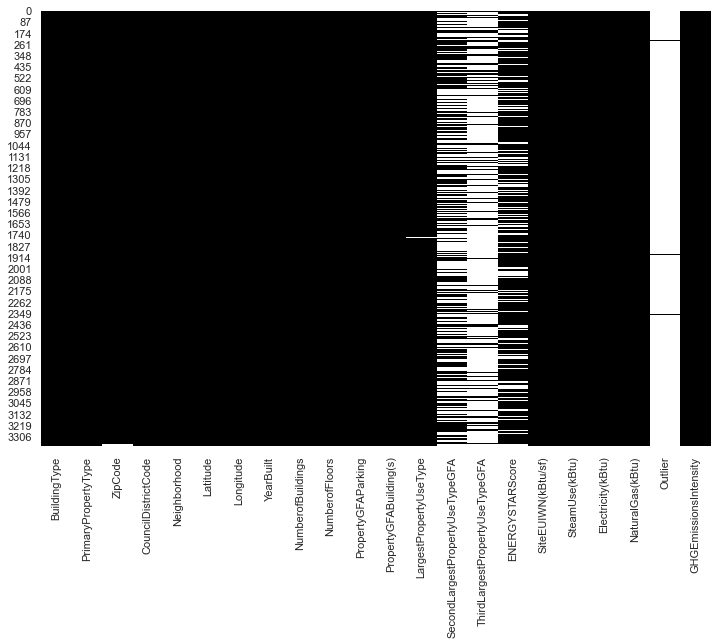

In [44]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
sns.heatmap(df.isna(), cmap=cmaps[6], cbar=False)

In [45]:
#cols_to_drop = ['SecondLargestPropertyUseType','SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseType','ThirdLargestPropertyUseTypeGFA']
cols_to_drop = ['SecondLargestPropertyUseTypeGFA','ThirdLargestPropertyUseTypeGFA']

'Outlier' est presque vide mais ses valeurs manquantes sont une info pour moi donc je le garde.  
GFA veut dire Gross Floor Area je pense d'après ce que j'ai trouvé sur Wikipedia donc ça serait la superficie de chaque bâtiment.
Je ne comprends pas bien la signification de Second et Third Property Use Type donc je m'en débarrasse pour l'instant.  
ENERGYSTARScore nous servira de target plus tard donc je le garde pour l'instant et je l'écarterai juste avant les fits qui ne le concernent pas.

In [46]:
df.drop(cols_to_drop, axis = 1, inplace = True)
for i in cols_to_drop:
    try:
        cols_cat.remove(i)
    except:
        cols_num.remove(i) #Je fais une utilisation un peu détournée de try except ici mais no problem

In [47]:
df.to_csv('df2.csv')
df2 = df.copy()
df.head(2)

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,0,88434,Hotel,60.0,84.300003,2003882.0,3946027.0,1276453.0,NaN,2.83
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,15064,88502,Hotel,61.0,97.900002,0.0,3242851.0,5145082.0,NaN,2.86


In [48]:
#df = df2

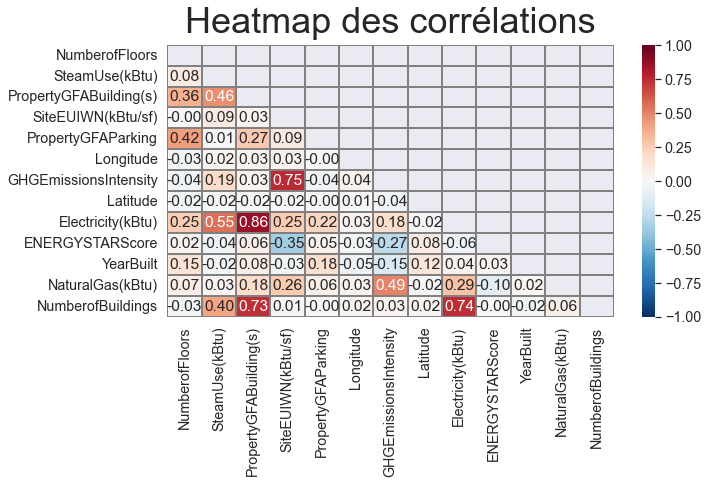

In [49]:
plt.figure(figsize=(10, 5))
sns.set(font_scale=1.3)
crrl = df.loc[:,cols_num].corr()
corrlmap = sns.heatmap(crrl, mask = np.triu(crrl), vmin=-1, vmax=1, annot=True, cmap=cmaps[2], fmt='3.2f', linewidths=0.01, linecolor='gray', cbar=True, )
corrlmap.set_title('Heatmap des corrélations', fontdict={'fontsize':36}, pad=12)
plt.savefig('corrlmap2.png', dpi=300, bbox_inches='tight')

>>-
## 13. Data visualization - Suppression d'éléments (lignes) problématiques

>>>-
### 131. Discrimination of unwanted elements

In [50]:
display(df.shape)
#df = df.loc['family' not in df['BuildingType'],:] # Maladroit, j'aimerais trouver une façon de rendre cette ligne fonctionnelle.
df3 = df[~df['BuildingType'].str.contains('family')]
df3 = my.resindx(df3)
df3.to_csv('df3.csv')

(3376, 20)

Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(1668, 20)


In [51]:
df = df3.copy()

>>>-
### 133. Outliers
Outliers va avant les missing values car il va avant l'imputation sinon on impute avec les valeurs parasites des outliers.

>>>>-
#### 1331. Outliers annoncés

In [52]:
#display(df[df['Outlier'].str.contains('High')]) # Ne fonctionne pas car les NaNs de cette série bloquent la method.
#display(df[df['Outlier'].isna() == False]) # Fonctionne mais visualisation en tableau pas bien intéressante.

Voir les outliers dans le tableau ne m'évoque rien.  
Je vais commencer par tracer les boxplots de chaque feature pour voir:
1. s'il y a des outliers.
2. si ces outliers sont bien (et sont uniquement) ceux indiqués dans le df originel.

In [53]:
%%script echo non_fonctionnel
# et pas terrible anyway
plt.figure(figsize=(20,30))
for i in range(df.shape[1]):
    plt.subplot(df.shape[1],1,i+1)
    plt.boxplot(df.iloc[:,i],vert=False)
    plt.ylabel(df.columns[i],rotation=0,labelpad=3*len(df.columns[i]))
    if i == 0:
        plt.title('Outliers ?')
plt.xlabel('Valeurs')
plt.xticks(labels=None)
plt.show()
#scipy qui vire les valeurs hors des 1.5*(Q3-Q1)

Couldn't find program: 'echo'


In [54]:
from sklearn.preprocessing import MinMaxScaler

In [55]:
scal = MinMaxScaler()
dfbox = pd.DataFrame(scal.fit_transform(df[cols_num]), index = df.index, columns = cols_num)
dfboxlow = dfbox.loc[df['Outlier'] == 'Low outlier',:]
dfboxhigh = dfbox.loc[df['Outlier'] == 'High outlier',:]

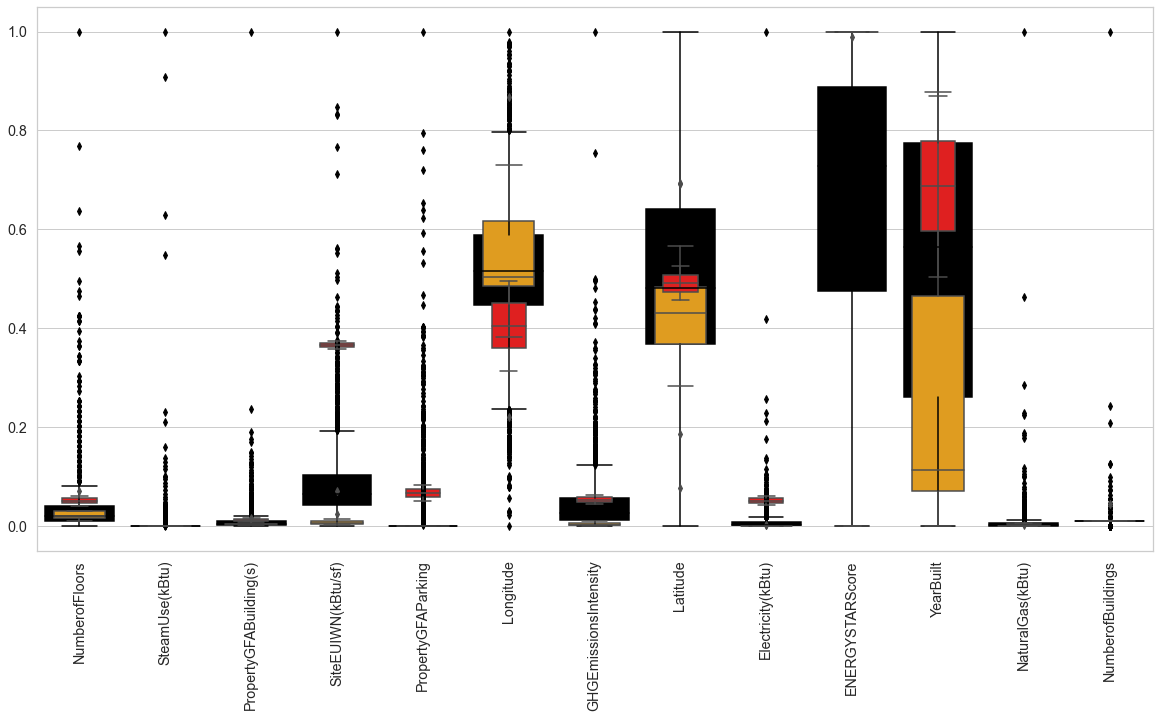

In [56]:
plt.figure(figsize=(20, 10))
with sns.axes_style("whitegrid"):
    sns.boxplot(data=dfbox, color='black')
    sns.boxplot(data=dfboxlow, color='orange',width=.6)
    sns.boxplot(data=dfboxhigh, color='red',width=.4)
plt.xticks(rotation=90)
print('')

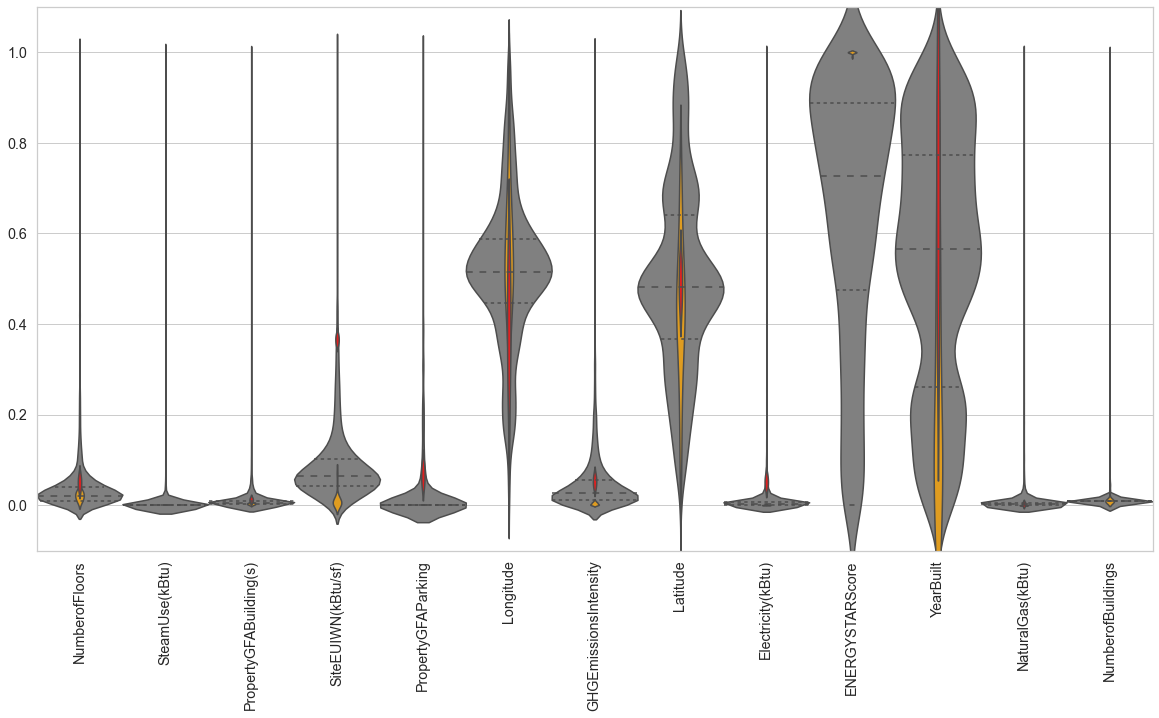

In [57]:
plt.figure(figsize=(20, 10))
with sns.axes_style("whitegrid"):
    sns.violinplot(data=dfbox, color='gray', scale='width', width=1, inner='quartiles') # , scale='area', scale='count', scale='width'
    sns.violinplot(data=dfboxlow, color='orange', scale='width', width=.1, inner=None) # , scale='area', width=1.4
    sns.violinplot(data=dfboxhigh, color='red', scale='width', width=.04, inner=None) # , scale='area', width=1.4
plt.ylim(-.1,1.1)
plt.xticks(rotation=90)
print('')

Les bâtiments renseignés en tant qu'outliers ne me semblent pas du tout être des outliers d'après ce tracé.  
Je pense d'après ces boxplots que certaines features ont une distibution exponentielle (décroissante) donc je vais regarder leur histogramme respectif et tenter un log.

In [58]:
%%script echo skipped
for co in cols_num:
    plt.figure(figsize=(3, 2))
    hst = df[co]
    #print(hst.isna().sum())
    hst.dropna(inplace=True)
    hst_val, hst_bin = np.histogram(hst, bins=50)
    hst = pd.DataFrame()
    hst.loc[:,'hst_bin'] = hst_bin[:-1] # Ou alors décaler d'un demi bin avec bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))].
    hst.loc[:,'hst_val'] = hst_val
    hst = hst[hst['hst_val'] != 0]
    #sns.scatterplot(hst)
    with sns.axes_style("whitegrid"):
        sns.scatterplot(hst['hst_bin'],hst['hst_val'])
    plt.title(('Hist de ' + co),fontsize=16)
    plt.xlabel(co,fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
print()

Couldn't find program: 'echo'


In [59]:
def hstplot(seris, strlog='log de ', hstsize=20):
    hst = seris.copy()
    hst.replace([np.inf, -np.inf], np.nan, inplace=True)
    hst.dropna(inplace=True)
    hst_val, hst_bin = np.histogram(hst, bins=50)
    hst = pd.DataFrame()
    hst.loc[:,'hst_bin'] = hst_bin[:-1] # Ou alors décaler d'un demi bin avec bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))].
    hst.loc[:,'hst_val'] = hst_val
    hst = hst[hst['hst_val'] != 0]
    with sns.axes_style("whitegrid"):
        sns.scatterplot(hst['hst_bin'], hst['hst_val'], legend=None, s=hstsize)
    plt.title(('Hist de ' + strlog + co),fontsize=16)
    plt.xlabel((strlog + co),fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
    plt.legend

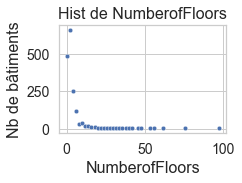

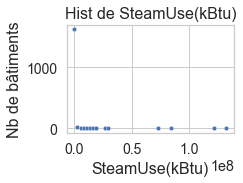

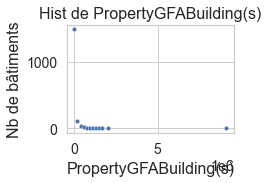

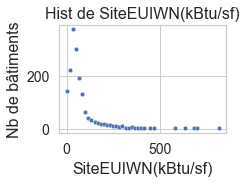

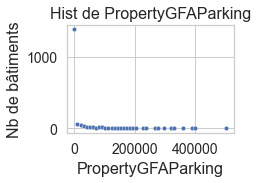

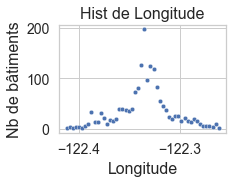

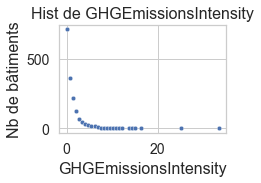

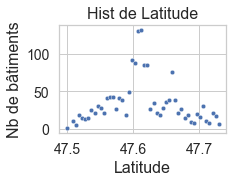

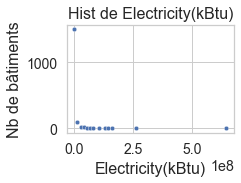

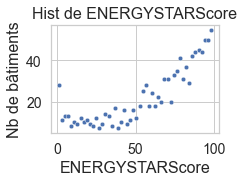

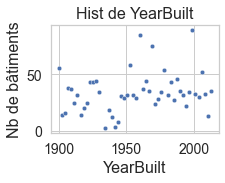

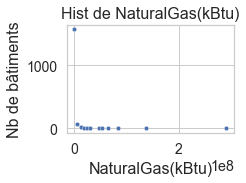

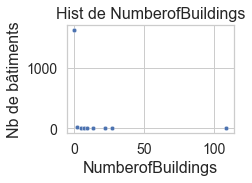

In [60]:
warnings.filterwarnings('ignore')
for co in cols_num:
    plt.figure(figsize=(3, 2))
    hstplot(df[co], strlog='')
print()

In [61]:
%%script echo skipped
for co in cols_num:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[co], kde=True) #, bins=int(df[co].max()-df[co].min()))
    plt.title(('Hist de ' + co),fontsize=16)
    plt.xlabel(co,fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
print()

Couldn't find program: 'echo'


In [62]:
for co in cols_num:
    print(co, (df[co] < 0).sum())

NumberofFloors 0
SteamUse(kBtu) 0
PropertyGFABuilding(s) 0
SiteEUIWN(kBtu/sf) 0
PropertyGFAParking 0
Longitude 1668
GHGEmissionsIntensity 1
Latitude 0
Electricity(kBtu) 1
ENERGYSTARScore 0
YearBuilt 0
NaturalGas(kBtu) 0
NumberofBuildings 0


In [63]:
for co in ['Electricity(kBtu)', 'GHGEmissionsIntensity']:
    print(co, df[co][df[co] < 0])
    df[co][df[co] < 0] = np.nan
    print(co, df[co][df[co] < 0])

Electricity(kBtu) 1605   -115417.0
Name: Electricity(kBtu), dtype: float64
Electricity(kBtu) Series([], Name: Electricity(kBtu), dtype: float64)
GHGEmissionsIntensity 1605   -0.02
Name: GHGEmissionsIntensity, dtype: float64
GHGEmissionsIntensity Series([], Name: GHGEmissionsIntensity, dtype: float64)


In [64]:
cols_num_log = list(set(cols_num).difference(set(['Longitude','Latitude','YearBuilt','ENERGYSTARScore'])))

In [65]:
df4 = df.copy()
for co in cols_num_log:
    df4[co] = np.log(df4[co]+1) # Je mets +1 pour éviter les valeurs <0 et surtout -inf (qui fausse les boxplot et bug avec ).
                                # Je me permets ce +1 car toutes les cols_num_log ont des valeurs qui évoluent dans une range bien plus "haute" que [0,1].
df4.to_csv('df4.csv')

In [66]:
%%script echo skipped
for co in cols_num:
    plt.figure(figsize=(3, 2))
    hst = df[co]
    #print(hst.isna().sum())
    hst.dropna(inplace=True)
    hst_val, hst_bin = np.histogram(hst, bins=50)
    hst = pd.DataFrame()
    hst.loc[:,'hst_bin'] = hst_bin[:-1] # Ou alors décaler d'un demi bin avec bins_mean = [0.5 * (bins[i] + bins[i+1]) for i in range(len(n))].
    hst.loc[:,'hst_val'] = hst_val
    hst = hst[hst['hst_val'] != 0]
    #sns.scatterplot(hst)
    with sns.axes_style("whitegrid"):
        sns.scatterplot(hst['hst_bin'],hst['hst_val'])
    plt.title(('Hist de ' + co),fontsize=16)
    plt.xlabel(co,fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
print()

Couldn't find program: 'echo'


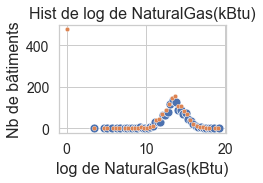

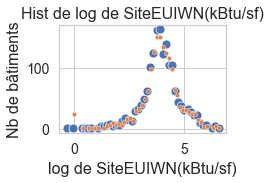

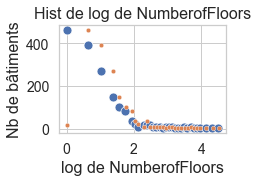

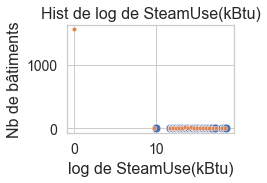

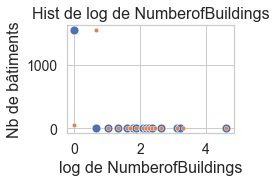

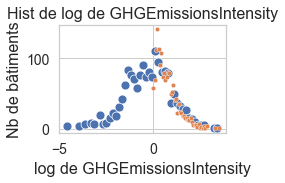

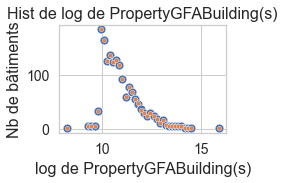

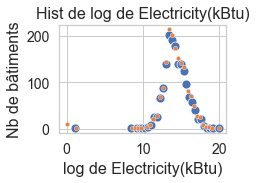

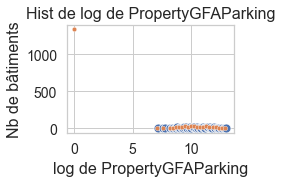

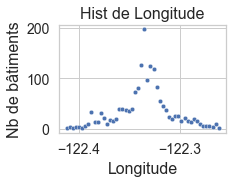

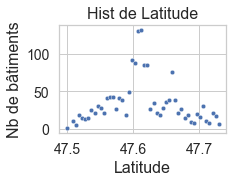

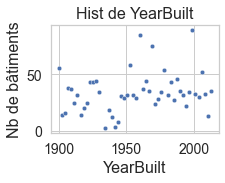

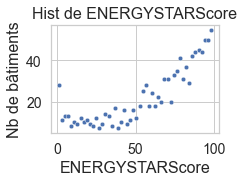

In [67]:
warnings.filterwarnings('ignore')
for co in cols_num_log:
    plt.figure(figsize=(3, 2))
    hstplot(np.log(df[co]), strlog='log de ', hstsize=80)
    hstplot(df4[co], strlog='log de ')
for co in ['Longitude','Latitude','YearBuilt','ENERGYSTARScore']:
    plt.figure(figsize=(3, 2))
    hstplot(df4[co], strlog='') #, bins=int(df[co].max()-df[co].min()))
print()

In [68]:
%%script echo skipped
warnings.filterwarnings('ignore')
for co in cols_num_log:
    plt.figure(figsize=(3, 2))
    sns.histplot(np.log(df[co]), kde=True, color='red')
    sns.histplot(df4[co], kde=True, color='orange') #, bins=int(df[co].max()-df[co].min()))
    plt.title(('Hist de log de ' + co),fontsize=16)
    plt.xlabel(('log de ' + co),fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
for co in ['Longitude','Latitude','YearBuilt','ENERGYSTARScore']:
    plt.figure(figsize=(3, 2))
    sns.histplot(df4[co], kde=True) #, bins=int(df[co].max()-df[co].min()))
    plt.title(('Hist de ' + co),fontsize=16)
    plt.xlabel(co,fontsize=16)
    plt.xticks(fontsize=14)
    plt.ylabel('Nb de bâtiments',fontsize=16)
    plt.yticks(fontsize=14)
print()

Couldn't find program: 'echo'


In [69]:
scal = MinMaxScaler()
dfbox = pd.DataFrame(scal.fit_transform(df4[cols_num]), index = df.index, columns = cols_num)
dfboxlow = dfbox.loc[df['Outlier'] == 'Low outlier',:] # ATTENTION CECI FONCTIONNE SEULEMENT SI LE FIT TRANSFORM NE ME SHUFFLE PAS L'INDEX DE dfbox PAR RAPPORT À L'INDEX DE df.
dfboxhigh = dfbox.loc[df['Outlier'] == 'High outlier',:] # Normalement ça ce ne devrait pas se produire mais vu que je vois l'ordre des colonnes qui diffère dans mes heatmap de corr() à chaque restart de kernel j'ai des doutes.

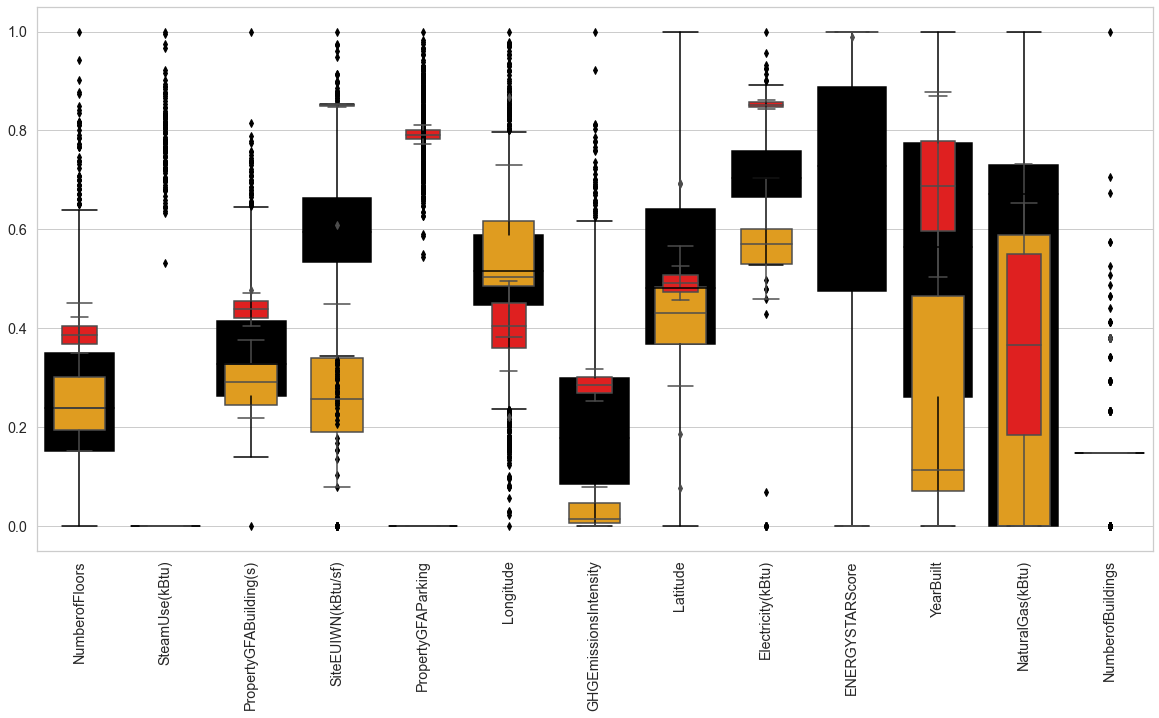

In [70]:
plt.figure(figsize=(20, 10))
with sns.axes_style("whitegrid"):
    sns.boxplot(data=dfbox, color='black')
    sns.boxplot(data=dfboxlow, color='orange',width=.6)
    sns.boxplot(data=dfboxhigh, color='red',width=.4)
plt.xticks(rotation=90)
print('')

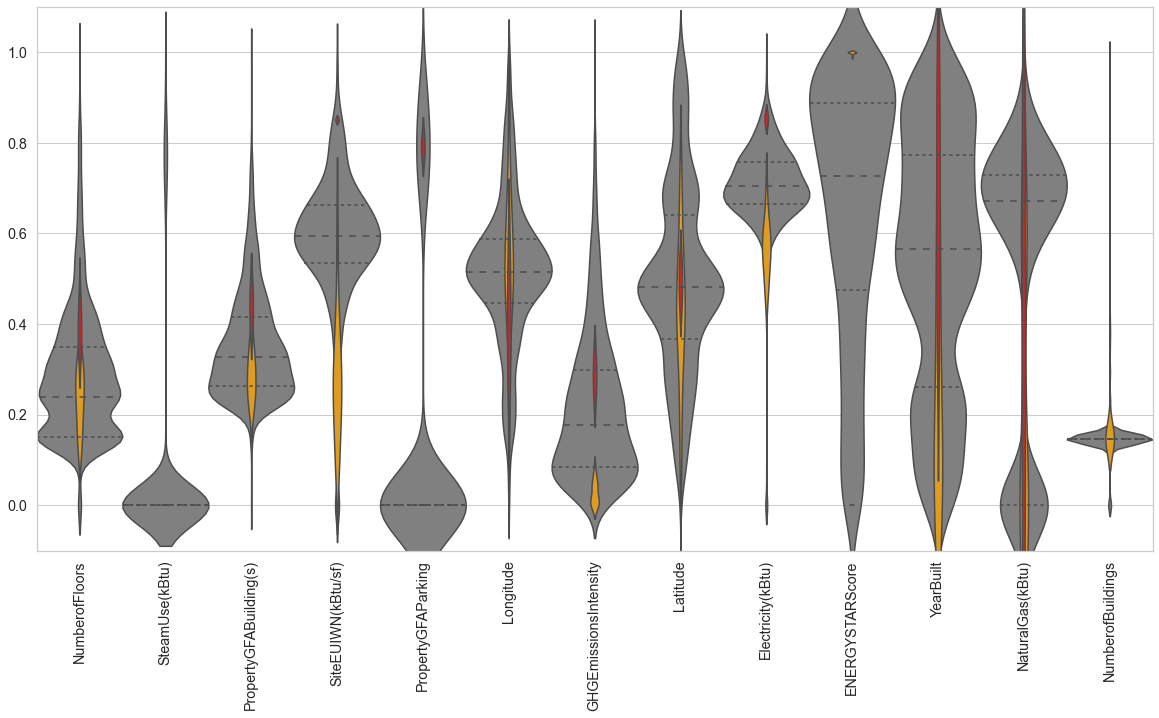

In [71]:
plt.figure(figsize=(20, 10))
with sns.axes_style("whitegrid"):
    sns.violinplot(data=dfbox, color='gray', scale='width', width=1, inner='quartiles') # , scale='area', scale='count', scale='width'
    sns.violinplot(data=dfboxlow, color='orange', scale='width', width=.1, inner=None) # , scale='area', width=1.4
    sns.violinplot(data=dfboxhigh, color='red', scale='width', width=.04, inner=None) # , scale='area', width=1.4
plt.ylim(-.1,1.1)
plt.xticks(rotation=90)
print('')

Je ne suis toujours pas convaincu que ces bâtiments signalés comme outliers sont vraiment des outliers.  
J'ai encore beaucoup de mal à identifier clairement des outliers et j'aimerais trouver une méthode plus propre et plus convaincante/tranchée que ce que je viens de faire.

>>>>-
#### 1332. Recherche d'outliers supplémentaires
Cette étape s'est mélangée avec l'étape d'étude des bâtiments signalés comme outliers.

>>>-
### 132. Missing values #2
(éléments mal renseignés à supprimer, éléments presque parfaitement renseignés à imputer)

>>>>-
#### 1321. 'Empty' elements

In [72]:
lim_nan = np.floor(len(df.columns)/6)

In [73]:
display(df.isna().sum(axis=1)[df.isna().sum(axis=1) > lim_nan])

568     9
1423    9
dtype: int64

In [74]:
display(df[df.isna().sum(axis=1) > lim_nan])

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity
568,NonResidential,Small- and Mid-Sized Office,98104.0,7,DOWNTOWN,47.60380,-122.33293,1924,NaN,4,0,63150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1423,NonResidential,Mixed Use Property,98105.0,4,NORTHEAST,47.66182,-122.31345,1928,NaN,2,0,20760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ici on a des éléments pour lesquels peu d'information a été remplie concernant les features numériques.  
Ça ne me semble pas délirant de choisir de les garder pour imputer leurs valeurs mais je vais quand même les supprimer ici.

In [75]:
display(df[df.isna().sum(axis=1) == lim_nan])

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),Outlier,GHGEmissionsIntensity
347,NonResidential,Self-Storage Facility,98107.0,6,BALLARD,47.66838,-122.39310,1946,2.0,2,0,111445,NaN,NaN,51.000000,0.0,3.007514e+06,2.689958e+06,NaN,1.47
1368,NonResidential,Restaurant,98104.0,2,DOWNTOWN,47.59697,-122.32474,1913,1.0,3,0,28800,NaN,NaN,32.500000,0.0,4.029070e+05,4.970170e+05,NaN,1.01
1605,NonResidential,Small- and Mid-Sized Office,98122.0,3,CENTRAL,47.61432,-122.31257,2013,1.0,6,0,52000,Office,100.0,5.000000,0.0,NaN,0.000000e+00,NaN,NaN
1652,Nonresidential COS,Mixed Use Property,NaN,5,NORTH,47.70541,-122.32232,2005,1.0,1,0,20616,Other - Recreation,NaN,30.900000,0.0,6.369655e+05,0.000000e+00,NaN,0.22
1653,Nonresidential COS,Other,NaN,3,CENTRAL,47.59905,-122.29787,2013,1.0,1,0,11685,Prison/Incarceration,NaN,82.900002,0.0,3.472887e+05,5.037650e+05,NaN,2.50
1654,Nonresidential COS,Other,NaN,6,BALLARD,47.69330,-122.37717,2010,1.0,1,0,11968,Prison/Incarceration,NaN,71.800003,0.0,4.032431e+05,3.801800e+05,NaN,1.92
1655,Nonresidential COS,Other,NaN,5,NORTH,47.72126,-122.29735,1949,1.0,1,0,11285,Prison/Incarceration,NaN,62.599998,0.0,4.317954e+05,2.138700e+05,NaN,1.27
1656,Nonresidential COS,Other,NaN,6,BALLARD,47.67295,-122.39228,1911,1.0,1,0,16795,Other - Recreation,NaN,59.000000,0.0,5.421344e+05,3.944820e+05,NaN,1.47
1657,Nonresidential COS,Other,NaN,6,BALLARD,47.67734,-122.37624,1972,1.0,1,0,12769,Other - Recreation,NaN,420.600006,0.0,1.205173e+06,3.912135e+06,NaN,16.93
1659,Nonresidential COS,Other,NaN,3,EAST,47.63228,-122.31574,1912,1.0,1,0,23445,Other - Recreation,NaN,286.500000,0.0,1.260870e+06,4.715376e+06,NaN,11.06


Ceux-là c'est un tout petit manque d'information donc leurs infos seront imputées.

In [76]:
df5 = df[df.isna().sum(axis=1) < (lim_nan + 1)]
display(df5.shape)
my.resindx(df5)
df5.to_csv('df5.csv')

(1666, 20)

Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(1666, 20)


In [77]:
df = df5.copy()

>>>>-
#### 1322. Imputation

In [78]:
for co in df.loc[:,df.isna().sum() > 0].columns:
    try:
        #print(f"{(co + ':'):40}", f"{(': mean: ' + df[co].mean()):20}", f"{(': std: ' + df[co].std()):20}")
        print(f"{(co + ':'):31}", f"{' median: ':4s}", f"{df[co].median():10.2f}", f"{'':12s}", f"{' std: ':4s}", f"{df[co].std():12.2f}")
    except:
        print(f"{(co + ':'):27}", f"{' top (mode): ':5s}", f"{df[co].describe()[2]:20}", f"{'':1s}", f"{' freq: ':3s}", f"{df[co].describe()[3]:12.2f}")

#        print(co, ': top: ', df[co].describe()[2], ': freq: ', df[co].describe()[3])
        

ZipCode:                         median:    98109.00               std:         18.44
LargestPropertyUseType:      top (mode):  Office                  freq:        497.00
ENERGYSTARScore:                 median:       73.00               std:         28.49
SiteEUIWN(kBtu/sf):              median:       53.90               std:         75.03
Electricity(kBtu):               median:  1612547.00               std:   20802460.10
Outlier:                     top (mode):  Low outlier             freq:         15.00
GHGEmissionsIntensity:           median:        0.88               std:          2.34


In [79]:
df.loc[df['ZipCode'].isna(),'ZipCode'] = 98116.5 #Will get OneHotted anyway.
#df.loc[df['NumberofBuildings'].isna(),'NumberofBuildings'] = df['NumberofBuildings'].median() # Inutile car après nettoyage il ne manque plus de valeurs dans cette feature.
df.loc[df['LargestPropertyUseType'].isna(),'LargestPropertyUseType'] = df['LargestPropertyUseType'].describe()[2]
#df.loc[df['ENERGYSTARScore'].isna(),'ENERGYSTARScore'] = df['ENERGYSTARScore'].median() # NON SURTOUT PAS. On ne l'imputera pas. Je supprimerai les lignes problématiques lorsqu'on le prendra comme target.
#df.loc[df['SiteEUIWN(kBtu/sf)'].isna(),'SiteEUIWN(kBtu/sf)'] = ?
#df.loc[df['Electricity(kBtu)'].isna(),'Electricity(kBtu)'] = ?
#df.loc[df['NaturalGas(kBtu)'].isna(),'NaturalGas(kBtu)'] = ? # Inutile car après nettoyage il ne manque plus de valeurs dans cette feature.
#df.loc[df['Outlier'].isna(),'Outlier'] = 'not an outlier'
df = df.drop('Outlier', axis=1)
cols_cat.remove('Outlier')
#df.loc[df['GHGEmissionsIntensity'].isna(),'GHGEmissionsIntensity'] = df['GHGEmissionsIntensity'].median() ?

Pour l'imputation knn je ne peux pas split par ttsplit car ttsplit va me mettre des éléments à valeurs manquantes dans mon ytr.  
Mal dit.  
Je vais découper le df à la main pour train sur les éléments full et imputer par predict sur le "ts" qui n'est pas un ts mais juste la liste des éléments non full.

In [80]:
cols_txt = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType','ENERGYSTARScore'] # ENERGYSTARScore n'est pas du texte mais pour ne pas l'imputer je l'ajoute dans cette list.
cols_flt = list(set(df.columns).difference(set(cols_txt)))

In [81]:
#from scipy import interpolate
from sklearn.impute import KNNImputer
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#imp = IterativeImputer(max_iter=10, random_state=0)
imp = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

ztr = df.iloc[df.dropna().index,:].loc[:,[co for co in cols_flt]]
zts = df.loc[df[df.isna().sum(axis=1) > 0].index,[co for co in cols_flt]]
imp.fit(ztr)
dfs2 = pd.DataFrame(imp.transform(zts), columns=cols_flt, index=df[df.isna().sum(axis=1) > 0].index)

In [82]:
print(df.shape, ztr.shape, zts.shape)

(1666, 19) (1092, 14) (574, 14)


In [83]:
(dfs2 - zts).isna().head(2)

,YearBuilt,NaturalGas(kBtu),Longitude,SiteEUIWN(kBtu/sf),NumberofFloors,SteamUse(kBtu),NumberofBuildings,GHGEmissionsIntensity,PropertyGFABuilding(s),Latitude,CouncilDistrictCode,Electricity(kBtu),PropertyGFAParking,ZipCode
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [84]:
df.isna().sum()[df.isna().sum() > 0]

ENERGYSTARScore          572
SiteEUIWN(kBtu/sf)         1
Electricity(kBtu)          1
GHGEmissionsIntensity      1
dtype: int64

In [85]:
df.loc[dfs2.index,dfs2.columns] = dfs2

In [86]:
df.isna().sum()[df.isna().sum() > 0]

ENERGYSTARScore    572
dtype: int64

In [87]:
df.to_csv('df6.csv')
df6 = df.copy()

In [88]:
with open("cols_cat.txt", "w") as f:
    for s in cols_cat:
        f.write(s +"\n")

In [89]:
with open("cols_num.txt", "w") as f:
    for s in cols_num:
        f.write(s +"\n")

>>-
## 14. 

>>-
## 18. Auto feature selection
Je voulais faire un SelectKBest à un moment mais c'était trop tôt dans le nettoyage. Là ça me semble inutile, à voir.

>-
# 2. Exploration

In [90]:
df.head()

,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,ENERGYSTARScore,SiteEUIWN(kBtu/sf),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),GHGEmissionsIntensity
0,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,0,88434,Hotel,60.0,84.300003,2003882.00,3946027.0,1276453.0,2.83
1,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,15064,88502,Hotel,61.0,97.900002,0.00,3242851.0,5145082.0,2.86
2,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,196718,759392,Hotel,43.0,97.699997,21566554.00,49526664.0,1493800.0,2.19
3,NonResidential,Hotel,98101.0,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,0,61320,Hotel,56.0,113.300003,2214446.25,2768924.0,1811213.0,4.67
4,NonResidential,Hotel,98121.0,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,62000,113580,Hotel,75.0,118.699997,0.00,5368607.0,8803998.0,2.88


Ce dataset a une composante géographique, profitons-en pour en visualiser la distribution de quelques features dans la ville.

<img src="Screenshot 2022-09-14 202844.png"/>

In [91]:
sns.set_style("whitegrid")    

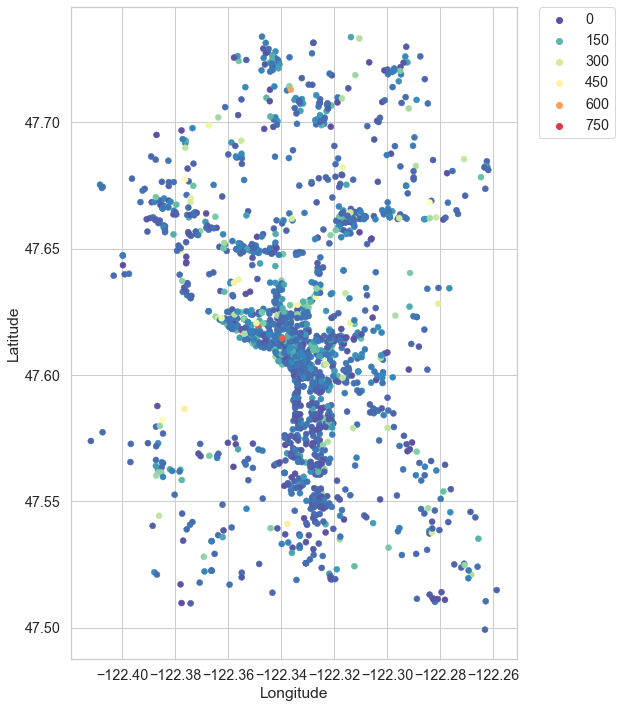

In [92]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='SiteEUIWN(kBtu/sf)', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

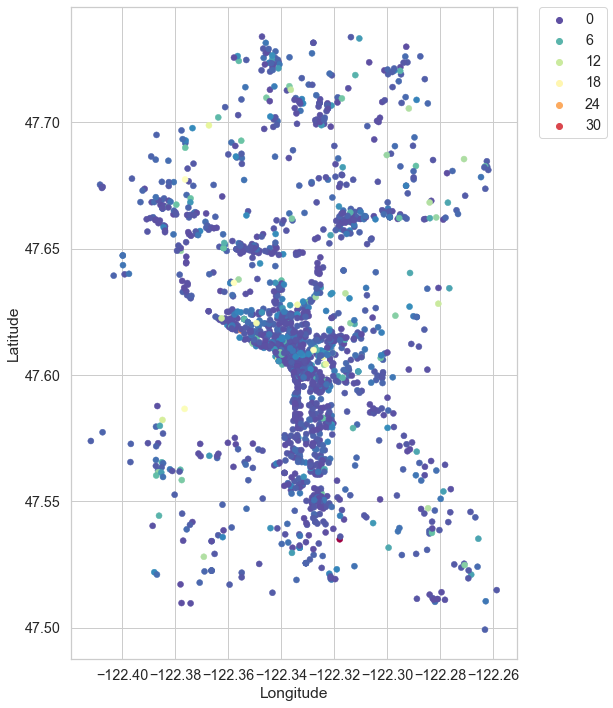

In [93]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='GHGEmissionsIntensity', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Pour nos targets la localisation des bâtiments dans la ville semble importer peu.

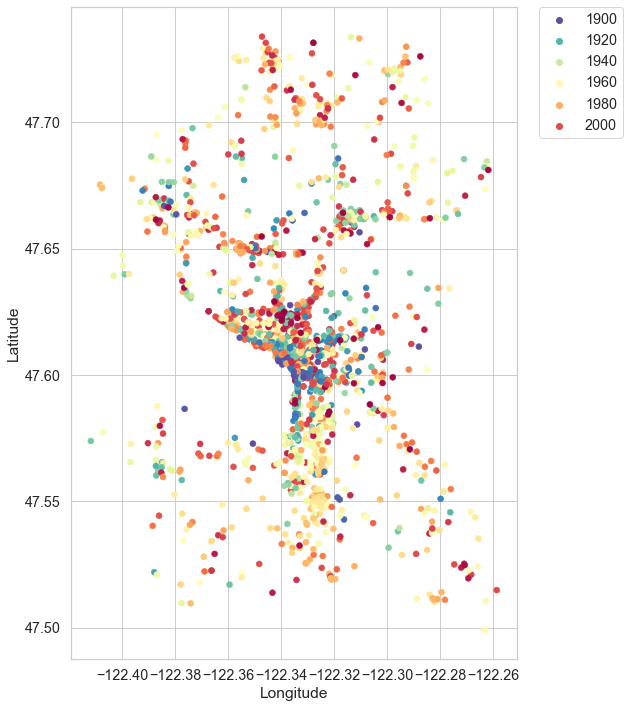

In [94]:
plt.figure(figsize=(8,12))
with sns.axes_style("whitegrid"):
    sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='YearBuilt', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

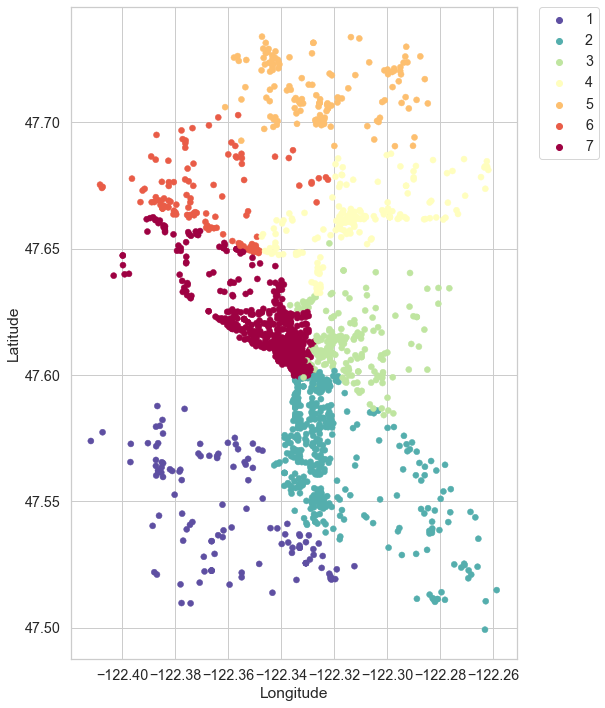

In [95]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='CouncilDistrictCode', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

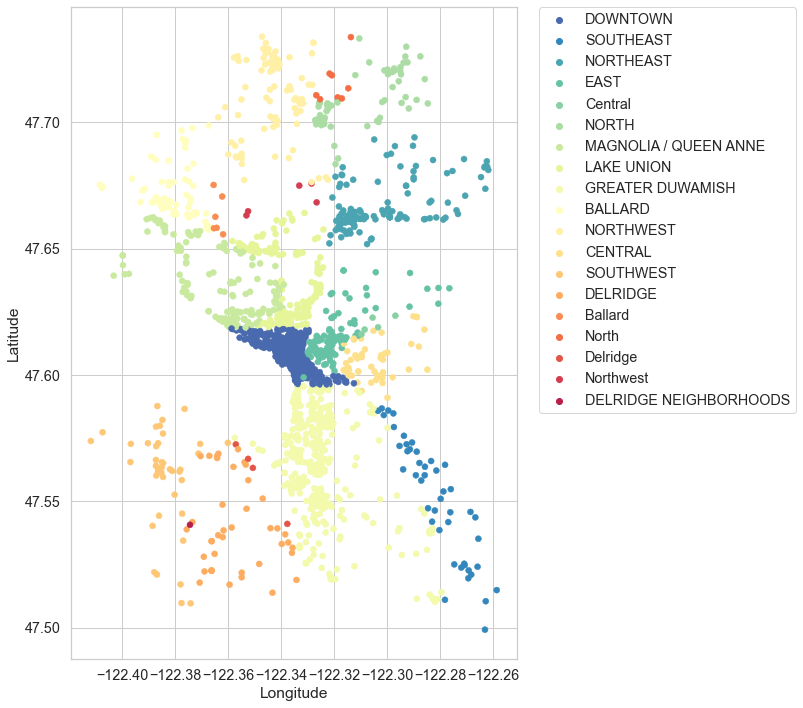

In [96]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='Neighborhood', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

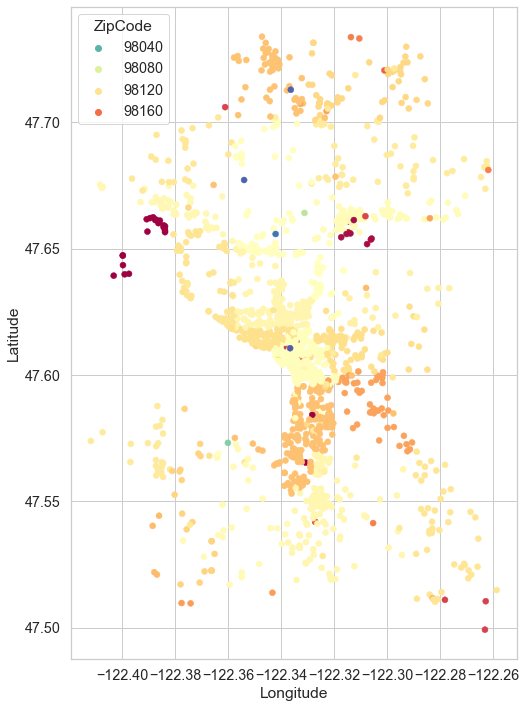

In [97]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='ZipCode', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

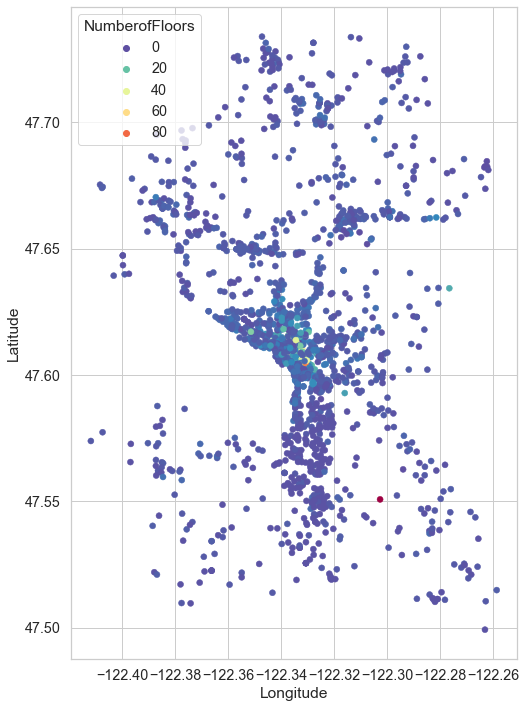

In [98]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='NumberofFloors', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'

<AxesSubplot:xlabel='Longitude', ylabel='Latitude'>

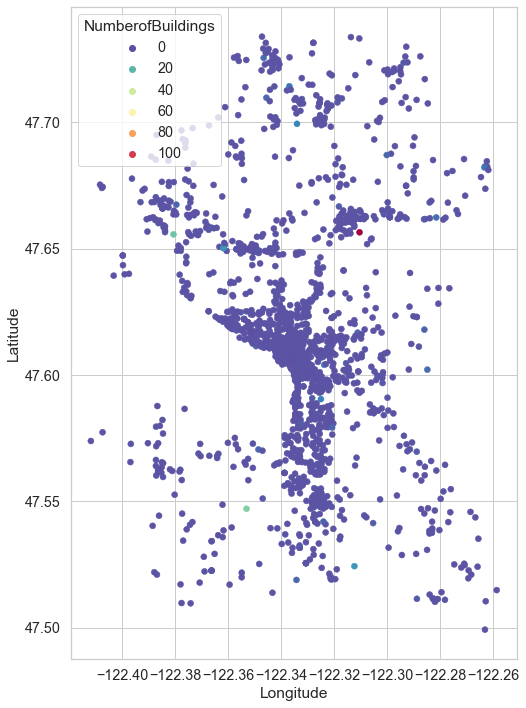

In [99]:
plt.figure(figsize=(8,12))
sns.scatterplot(x='Longitude', y='Latitude', data=df, hue='NumberofBuildings', edgecolor=None, palette='Spectral_r') # 'rainbow', 'viridis'

Les features géographiques ont été correctement remplies. Leur tracé sur la carte fait sens.

In [100]:
r=

SyntaxError: invalid syntax (2666259821.py, line 1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def subs(a, b):
    if type(b) == list:
        if type(b[0]) == list:
            for i in range(len(b)):
                a = list(set(a).difference(set(b[i])))
            return a
        else:
            print('Le 2nd argument doit être une liste de listes.')
    else:
        print('Les arguments doivent être des listes')

In [ ]:
#print(df.head())
#print(cols_cat)
#print(cols_num)
print(subs(df.columns, [cols_num, cols_cat]))
print(subs(cols_num, [list(df.columns)]))
print(subs(cols_cat, [list(df.columns)]))

In [ ]:
#ztr, zts = train_test_split(df, test_size=0.2, random_state=5)
drops = ['SiteEUIWN(kBtu/sf)','ENERGYSTARScore','GHGEmissionsIntensity']
X = df.drop(drops, axis=1)
for i in drops:
    cols_num.remove(i)
y = df['SiteEUIWN(kBtu/sf)']
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.2, random_state=5)

In [ ]:
print(subs(df.columns, [cols_num, cols_cat]))
print(subs(cols_num, [list(df.columns)]))
print(subs(cols_cat, [list(df.columns)]))

In [ ]:
Xtr.to_csv('Xtr.csv') # Ça c'est pour le P4_tests

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNetCV
from sklearn import set_config, svm
set_config(display="diagram")
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

J'avais déjà imputé toutes les valeurs manquantes donc le SimpleImputer ne sert à rien ici, c'est juste pour utiliser les pipelines.

In [ ]:
def pipeline_t(i, j, k):
    ppln_num = make_pipeline(SimpleImputer(strategy='median'), j)
    ppln_cat = make_pipeline(SimpleImputer(strategy='most_frequent'), i)
    preprocessor = make_column_transformer((ppln_num, cols_num), (ppln_cat, cols_cat))
    model = make_pipeline(preprocessor, k)
    #model.fit(Xtr, ytr)
    return model

Je ne suis pas très content de la solution handle_unknown='ignore' aveugle.  
Dans une situation réelle j'aurais pris le temps de nettoyer les entrées problématiques (nunique() < 3 par exemple) pour ne pas avoir à utiliser le handle_unknown='ignore'.  
(attention nunique sur le df donne le nombre d'uniques différents par colonne, je ne sais pas si nunique dans une colonne donne ce que je veux, à savoir le nombre d'occurence de chaque unique dans cette colonne)

In [ ]:
par_Ridge = {
    'ridge__alpha' : [.1, .3, 1, 3, 10]
}
par_Lasso = {
    'lasso__alpha' : [.1, .3, 1, 3, 10]
}
par_ENCV = {
    'elasticnetcv__l1_ratio' : [.1, .3, 1, 3, 10],
    'elasticnetcv__n_alphas' : [30, 100]
}
params = [par_Ridge, par_Lasso, par_ENCV] # S'assurer que l'ordre des estimateurs est le même ici que dans ma loop. (dict ou nouvelle classe)

GridSearchCV(, scoring='rmse')  
GridSearchCV(, scoring='mae')  
"coefficients des variables en fonction de la pénalisation"  
"visualisation des erreurs en fonction des variables du modèle"  
skewness pour log de certaines features dans la pipeline  
justif (ridge moins complexe que lasso (?) etc)  
feature importance: shap

In [ ]:
%%script echo v1
warnings.filterwarnings('ignore')
for i in [TargetEncoder(), OneHotEncoder(sparse=False, handle_unknown='ignore')]: # Le handle_unknown=ignore ne me plaît pas du tout, autant modifier les valeurs de tous les uniques qui sont uniques (voire même tous les uniques qui sont seulement en x2 ou x3 aussi) en 'other'.
    for j in [RobustScaler(), StandardScaler()]: # Je n'ai toujours pas supprimé les outliers donc StandardScaler sera mauvais pour l'instant.
        n_k = 0
        #for k in [Ridge(alpha=1), Lasso(alpha=1), ElasticNetCV(alpha=1), svm.SVR(kernel='linear')]:
        for k in [Ridge(), Lasso(), ElasticNetCV()]:
            model = pipeline_t(i, j, k)
            print('With ', str(i), ', ', str(j), ' and ', str(k), ':')
            #%timeit print('scores: {a:8.3f} {b:8.3f}'.format(a = model.score(Xts, yts), b = model.score(Xts, yts)))
            print('scores: {a:8.3f} {b:8.3f}'.format(a = model.score(Xts, yts), b = model.score(Xts, yts)))
            grid = GridSearchCV(model, param_grid=params[n_k], cv=5, scoring='r2')
            grid.fit(Xtr, ytr)
            print('best_params: ', grid.best_params_, ',      best_score: {a:8.3f}'.format(a = grid.best_score_))
            n_k += 1

In [ ]:
import timeit

In [ ]:
warnings.filterwarnings('ignore')
for i in [TargetEncoder(), OneHotEncoder(sparse=False,handle_unknown='ignore')]:
    for j in [RobustScaler(), StandardScaler()]: # Je n'ai toujours pas supprimé les outliers donc StandardScaler sera mauvais pour l'instant.
        #enumerate (transforme tableau en dict)
        #for k in [Ridge(alpha=1), Lasso(alpha=1), ElasticNetCV(alpha=1), svm.SVR(kernel='linear')]:
        #for k in [Ridge(), Lasso(), ElasticNetCV()]:
        for k_index, k in enumerate([DummyRegressor(strategy="mean"), Ridge(), Lasso(), ElasticNetCV()]):
            start_time = timeit.default_timer()
            model = pipeline_t(i, j, k)
            print('With ', str(i), ', ', str(j), ' and ', str(k), ':')
            grid = GridSearchCV(model, param_grid=params[k_index], cv=5, scoring='r2')
            grid.fit(Xtr, ytr)
            model.fit(Xtr, ytr)
            print('scores: {a:8.3f} {b:8.3f}'.format(a = model.score(Xts, yts), b = model.score(Xts, yts)))
            #print('scores: {a:8.3f} {b:8.3f}'.format(a = grid.best_estimator_.score(Xts, yts), b = model.score(Xts, yts)))
            print('best_params: ', grid.best_params_, ',      best_score: {a:8.3f}'.format(a = grid.best_score_))
            print("--- %s seconds ---" % (timeit.default_timer() - start_time))

In [ ]:
%%script echo trop_intense_pour_le_pc
warnings.filterwarnings('ignore')
model = pipeline_t(TargetEncoder(), RobustScaler(), svm.SVR(kernel='linear'))
model.score(Xts, yts)

In [ ]:
grid.best_params_

In [ ]:
grid.best_estimator_

In [ ]:

cv = KFold(5, random_state=0)
cross_val_score(Ridge(), X, y, cv=cv)

In [ ]:
#voir shap mlinear explainers pour voir la feature importance , et tree regressor

In [ ]:
#print(Xtr['ZipCode'].unique())
#print(Xts['ZipCode'].unique())

<img src="Screenshot_2022-09-01_070904.png"/>

L'OHE me retourne un nombre de colonnes différent pour les tr set et ts set car il ne voit pas les mêmes valeurs unique() notamment dans 'ZipCode', donc le modèle n'arrive pas à travailler sur le ts set après avoir fit le tr set, donc je dois faire le OHE avant de ttsplit à mon avis.
MachineLearnia propose dans l'ordre: ttsplit, Encoder, Scaler, Imputer, Selection, Extraction. ((PolynomialFeatures(), StandardScaler(), SGDClassifier(random_state=0)))
J'étais en train de faire: feature_selection à la main, Imputers (3), ttsplit, Scaler, Encoder, feature_selection (KBest)

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
nrgies = ['SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)']
chi2(df[cols_num], df[nrgies].sum())

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:

preds = modl.predict(Xts)
plt.scatter(Xts, yts)
plt.plot(Xts, preds, c='r')

>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
># Y. P3

In [ ]:
=r

In [ ]:
#df['aaa'] = [i[0] for i in df['aaa'].values]

In [ ]:
#df['aaa'] = np.where(df['bbb'] == beta, 1, 0)

In [ ]:
#df = df[[i for i in list(df) if i not in ['fff','ggg','hhh']]

In [ ]:
#df['aaa'] = df['aaa'].relace(np.nan, alpha)
#df['aaa'] = df['aaa'].relace(np.NaN, alpha)
#df['aaa'] = df['aaa'].fillna(df['aaa'].median())

In [ ]:
#i=3
#[i for ((i in range(5)) and (i not in range(2)))]
#[i for i in (range(5) and not range(2))]
#[i for i in range(5) and True]
#i = None
#del i

In [ ]:
# "df['est malade'] = df[viral_columns].sum(axis=1) >= 1" ???????????????? Check plusieurs colonnes de bools et sort une colonne OR.

In [ ]:
print(df.shape)
df = df[df.isna().mean(axis=1) < .6] 
#df = df.loc[:,(df.isna().mean() < .6)] à tester
df = resindx.resindx(df)

In [ ]:

print(df.shape)
#df = df[df['product_name'] != np.nan] # Ne fonctionne pas
'''
mask = 1 - df['product_name'].isna()
print(mask)
print(mask[:])
'''
#df = df.iloc[mask.index,:] # Ça ne supprime rien non plus puisque les lignes de mask qui valent 0
# ne sont pas delete et donc leur index est toujours là.
#df = df[mask[:]] # Là il ne comprend pas que je veux sélectionner des lignes et pas des colonnes.
df = df[df['product_name'].isna() == False]
df = resindx.resindx(df)

In [ ]:
df.duplicated(keep=False).sum()

In [ ]:
df['code'].duplicated(keep=False).sum()

In [ ]:
df['code'][df['code'].duplicated(keep=False) == True]

In [ ]:
df['code'][df['code'].duplicated(keep=False) == True].index[1]

In [ ]:
xx = df['code'][df['code'].duplicated(keep=False) == True].index[1]

In [ ]:
for i in range(0,df.shape[1]):
    print(df.columns[i], '                 ', df.iloc[4,i], '                          ', df.iloc[xx,i])

In [ ]:
df = df.drop(index=xx)
df = resindx.resindx(df)

>>## C.1. Choix d'imputations

In [ ]:
#percentcols_2 = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'calcium_100g', 'iron_100g']
percentcols_2 = ['fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g']

In [ ]:
print('  indicateur', "                          ", 'std', "                          ", 'median')
for i in percentcols_2:
    print(i, "                     ", df[i].std(), "                     ", df[i].median())

In [ ]:
plt.figure(figsize=(1,3))
plt.scatter('salt_100g',df['salt_100g'].isna().mean())
plt.title('Emptyness %',fontsize=16)
plt.xlabel('Indicator',fontsize=16)
plt.xticks(fontsize=14,rotation=90)
plt.ylabel('Missing values %',fontsize=16)
plt.yticks(fontsize=14)
plt.ylim(0,0.4)
print() # Je rajoute ça sinon il me print le détail de l'array des yticks.

In [ ]:
df['salt_100g'].fillna(df['salt_100g'].median(), inplace=True) #strategy=med

In [ ]:
df['additives_n'].fillna(0, inplace=True)

In [ ]:
plt.figure(figsize=(8,3))
plt.scatter(df.columns,df.isna().mean())
plt.title('Emptyness % for each indicator',fontsize=16)
plt.xlabel('Indicator',fontsize=16)
plt.xticks(fontsize=14,rotation=90)
plt.ylabel('Missing values %',fontsize=16)
plt.yticks(fontsize=14)
print() # Je rajoute ça sinon il me print le détail de l'array des yticks.

>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
>                                                                                                   .
> 
> 
># Z. Other

In [ ]:
=2

In [ ]:

#df['NumberofFloors'] = df['NumberofFloors'].astype(float)

In [ ]:
#cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
cmaps = ['vlag', 'twilight_shifted', 'RdBu_r', 'coolwarm', 'seismic', 'rainbow']


In [ ]:
#Touches opt macbook
#df•ë“‘{¶«¡Çø}—ô€Ù@≠÷…∞≤~ß◊©≈‡Ò∂ƒÌÏÈ¬µπœîºÚ†®êÂæÆÅÊ‚™ŸªïŒ∏Ó|ËÍÎË||||||Ì·∆∑Ω≥›⁄¢√∫ı¿•\±‰¥Ô–]ØÁÛ»å[’”„´Ÿ

In [ ]:
#print(f\"{name:30s} {average:4.1f}\") # Ça c'est ce que j'ai trouvé en ligne. 30 c'est l'espacement alloué, s c'est string, 4.1s ça n'affiche que la première lettre, 4.1f c'est pour afficher un float.\n",
#print(f\"{(i + ':'):20s} {j:30s}\") # Je l'ai adapté pour mon cas."

In [ ]:
#df.OSEBuildingID = df.OSEBuildingID.astype(float) # Fonctionne aussi
#df['OSEBuildingID'] = df['OSEBuildingID'].astype(float)

In [ ]:
for co in cols_cat:
    #print(f"{(co + ':'):34}", len(df.loc[:,co].value_counts().unique()))
    #print(f"{(co + ':'):34}", f"{len(df.loc[:,co].value_counts().unique()):2}")
    print('{a:34} {b:2}'.format(a = (co + ':'), b = len(df.loc[:,co].value_counts().unique())))
    #print('{a:34}'.format(a = (co + ':')), len(df.loc[:,co].value_counts().unique())) # Les 4 options donnent à peu près le même output.

In [ ]:
def is_int(element) -> bool:
    try:
        int(element)
        #float(element) pour is_float
        return True
    except ValueError:
        return False

In [ ]:
x = [int(i) for i in df21.columns if is_int(i)]
print(x)

***
Pour attribuer une *Docstring* à une method il faut utiliser le multiline commenting juste après la déclaration **def** comme ceci:

`def ma_method():
    '''
    ma_Docstring
    '''
    l'algorithme de ma_method`
***

In [ ]:
return()
stop()
break()
return
stop
break

<div class="alert alert-block alert-info"><b>Tip:</b> Use blue boxes (alert-info) for tips and notes.</div>

<div class="alert alert-block alert-warning"><b>Example:</b> Use yellow boxes for examples that are not inside code cells, or use for mathematical formulas if needed. Typically also used to display warning messages.</div>

<div class="alert alert-block alert-success"><b>Success:</b> This alert box indicates a successful or positive action.</div>

<div class="alert alert-block alert-danger"><b>Danger:</b> This alert box indicates a dangerous or potentially negative action.</div>

<p style="background:black">
<code style="background:black;color:white">C:\Users\Arnaud> pip3 install pandas
</code>
</p>

In [ ]:
print(df.loc[df['Position'].duplicated(keep=False),:])
#print(df[df['Position'].duplicated(keep=False)]) # idem
#print(df.loc[df.duplicated(keep=False),:]) # pas idem, et pas très safe d'ailleurs

In [ ]:
print(df.index)
print(df.loc[df['Age'].isna(),'Age'].index)